In [2]:
from models.autoencoder import Autoencoder
from data.hmaps import GridData

from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm

import numpy as np

import heapq


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def make_key(node):
    return (node.x, node.y, node.theta)


def h1(node, goal):
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])


In [5]:
class Node:
    def __init__(self, x, y, theta, cost, end, ppm, w = 1.0):
        self.x = x
        self.y = y
        self.theta = theta
        self.cost = cost  # g(n)
        self.parent = None
        self.ppm = ppm
        if not isinstance(end, tuple):
            end = (end.x, end.y, end.theta)
        self.f1 = self.cost + w * h1((x, y, theta), end)  # g(n) + h1(n)
        self.f2 = -ppm[(theta, x, y)]
        self.w = w
    
    def __lt__(self, other):
        return self.f1 < other.f1
    
    def __eq__(self, other):
        return (self.x, self.y, self.theta) == (other.x, other.y, other.theta)

    def __str__(self):
        return f"({self.x}, {self.y}, {self.theta})"

def get_neighbors(node, grid, end):
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
    neighbors = []

    left_theta = (node.theta - 1) % 4
    left = Node(node.x, node.y, left_theta, node.cost + 1, end, node.ppm, node.w)
    left.parent = node
    neighbors.append(left)
    
    right_theta = (node.theta + 1) % 4
    right = Node(node.x, node.y, right_theta, node.cost + 1, end, node.ppm, node.w)
    right.parent = node
    neighbors.append(right)
    
    dx, dy = directions[node.theta]
    if 0 <= node.x + dx < grid.shape[1] and 0 <= node.y + dy < grid.shape[2] and grid[node.theta][node.x + dx][node.y + dy] == 0:
        neighbor = Node(node.x + dx, node.y + dy, node.theta, node.cost + 1, end, node.ppm, node.w)
        neighbor.parent = node
        neighbors.append(neighbor)
        
    return neighbors

def make_path(root):
    res = []
    while root is not None:
        res.append(make_key(root))
        root = root.parent
    return res[::-1]

def search(grid, start, end, w=1.5, use_focal=True):
    open_list = []
    steps = 0

    heapq.heappush(open_list, (start.f1, start))
    
    closed_list = set()
    nodes_dict = {(make_key(start)): start}

    while open_list:
        steps += 1
        min_f1 = open_list[0][0]
        focal_bound = min_f1 * w

        if use_focal:
            focal_list = [node for _, node in open_list if node.f1 <= focal_bound]
        else:
            focal_list = [node for _, node in open_list]

        if not focal_list:
            break

        if use_focal:
            current = min(focal_list, key=lambda node: node.f2)
        else:
            current = min(focal_list, key=lambda node: node.f1)

        if current == end:
            return steps, make_path(current)

        open_list.remove((current.f1, current))
        closed_list.add(make_key(current))

        for neighbor in get_neighbors(current, grid, end):
            neighbor_key = make_key(neighbor)
            if neighbor_key not in closed_list:
                if neighbor_key not in nodes_dict:
                    nodes_dict[neighbor_key] = neighbor
                    heapq.heappush(open_list, (neighbor.f1, neighbor))
                else:
                    if neighbor.cost < nodes_dict[neighbor_key].cost:
                        open_list.remove((nodes_dict[neighbor_key].f1, nodes_dict[neighbor_key]))
                        nodes_dict[neighbor_key].cost = neighbor.cost
                        nodes_dict[neighbor_key].parent = current
                        nodes_dict[neighbor_key].f1 = neighbor.f1
                        nodes_dict[neighbor_key].f2 = neighbor.f2
                        heapq.heappush(open_list, (neighbor.f1, nodes_dict[neighbor_key]))

    return None, []


In [111]:
from collections import defaultdict

model = Autoencoder(mode="f")
model.load_from_checkpoint("theta-transpath-end.pth")
model.eval()

batch_size = 1
val_data = GridData(
    path='./TransPath_data_theta/test',
    mode="f"
)
val_dataloader = DataLoader(val_data, batch_size=batch_size,  shuffle=False, pin_memory=True)

metrics = defaultdict(lambda: defaultdict(list))
astar_metrics, astar_steps = [], []

def process(batch):
    map_design, start, goal, gt_hmap = batch

    s = [list(x.numpy()) for x in np.nonzero(start[0])][0]
    f = [list(x.numpy()) for x in np.nonzero(goal[0])][0]

    # TESTING ON RAW PREDICTIONS
    # inputs = torch.cat([map_design, start + goal], dim=1)
    # with torch.no_grad():
        # predictions = model(inputs)
    # ppm = predictions.squeeze(0)

    # TESTING ON gt-data
    ppm = gt_hmap.squeeze(0)

    for w in (1.1, 1.5, 2, 3, 5, 10):
        # WA*
        st = Node(s[1], s[2], s[0], 0, (f[1], f[2], f[0]), ppm, w)
        fin = Node(f[1], f[2], f[0], 0, (f[1], f[2], f[0]), ppm, w)

        steps, path = search(map_design.squeeze(0), st, fin, use_focal=False)
        metrics[w]["WA*"].append(steps)

        # Focal
        st = Node(s[1], s[2], s[0], 0, (f[1], f[2], f[0]), ppm)
        fin = Node(f[1], f[2], f[0], 0, (f[1], f[2], f[0]), ppm)

        steps, path = search(map_design.squeeze(0), st, fin, w=w, use_focal=True)
        metrics[w]["Focal"].append(steps)

    st = Node(s[1], s[2], s[0], 0, (f[1], f[2], f[0]), ppm)
    fin = Node(f[1], f[2], f[0], 0, (f[1], f[2], f[0]), ppm)
    steps, path = search(map_design.squeeze(0), st, fin, use_focal=False)
    astar_metrics.append(steps / len(path))
    astar_steps.append(steps)


In [112]:
from matplotlib import pyplot as plt
import seaborn as sns

torch.Size([4, 64, 64])


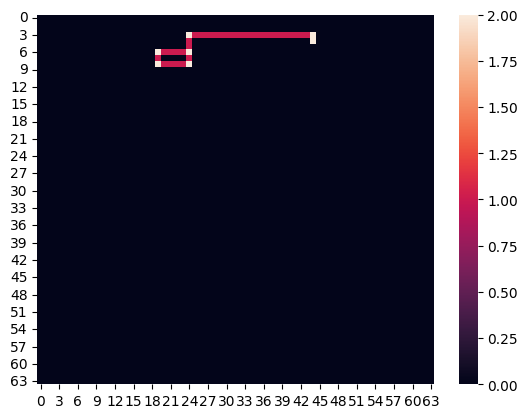

torch.Size([4, 64, 64])


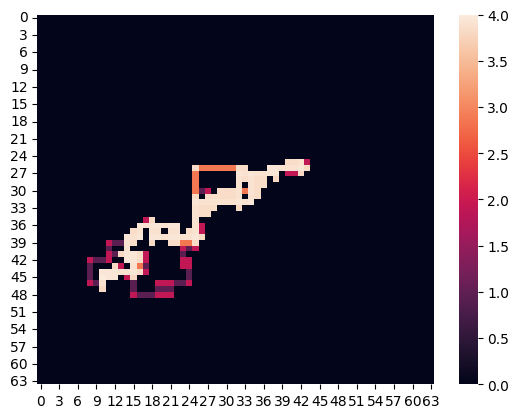

torch.Size([4, 64, 64])


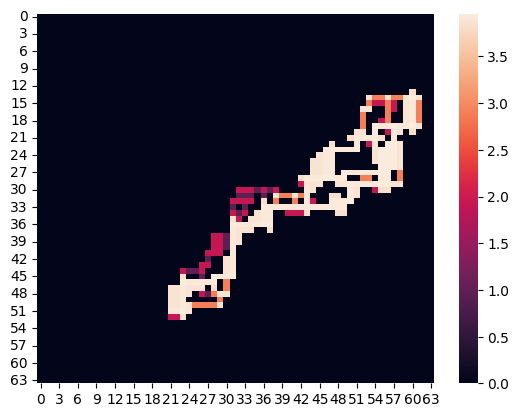

torch.Size([4, 64, 64])


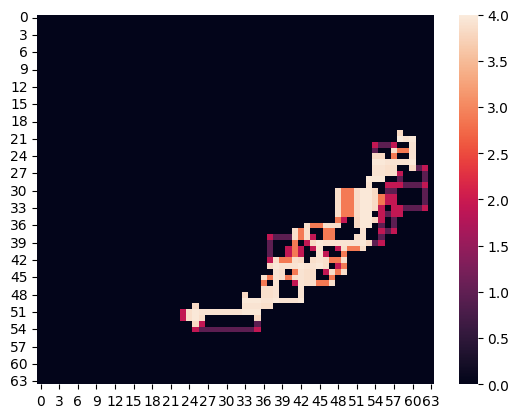

In [149]:
batch_size = 1
val_data = GridData(
    path='./TransPath_data_theta/test',
    mode="f"
)
val_dataloader = DataLoader(val_data, batch_size=batch_size,  shuffle=False, pin_memory=True)

for i, batch in enumerate(val_dataloader):
    map_design, start, goal, gt_hmap = batch
    print(gt_hmap.squeeze(0).shape)
    m = gt_hmap.squeeze(0)[0] + gt_hmap.squeeze(0)[1] + gt_hmap.squeeze(0)[2] + gt_hmap.squeeze(0)[3]    sns.heatmap(m)
    plt.show()
    if i == 3:
        break

In [113]:
for i, batch in enumerate(tqdm(val_dataloader)):
    if i == 100:
        break
    process(batch)

 10%|▉         | 100/1024 [00:51<07:59,  1.93it/s]


In [115]:
import pandas as pd

In [116]:
astar = np.array(astar_metrics)
astar_s = np.array(astar_steps)
pct = np.percentile(astar, 75)
idx = np.where(astar >= pct)

df = {}
for w in (1.1, 1.5, 2, 3, 5, 10):
    metrics[w]["WA*"] = np.array(metrics[w]["WA*"])
    metrics[w]["Focal"] = np.array(metrics[w]["Focal"])
    df[w] = pd.DataFrame({
        "WA*": metrics[w]["WA*"][idx],
        "Focal": metrics[w]["Focal"][idx],
        "A*": astar_s[idx],
    })

In [58]:
from IPython.display import HTML, display

In [117]:
for w in df:
    df[w]["Focal"] = df[w]["Focal"] / df[w]["A*"] * 100.0
    df[w]["WA*"] = df[w]["WA*"] / df[w]["A*"] * 100.0
    df[w]["A*"] = df[w]["A*"] / df[w]["A*"] * 100.0
    
    # display(HTML(f"<h3>Weight={w}</h3>"))
    # display(df[w])

comp = defaultdict(lambda: defaultdict(str))
for w in df:
    for m in ("Focal", "WA*"):
        mean = df[w][m].mean()
        std = df[w][m].std()
        comp[m][w] = f"{mean:.2f}+-{std:.2f}%"
pd.DataFrame(comp)


,Focal,WA*
1.1,30.34+-10.98%,81.84+-9.35%
1.5,13.69+-6.79%,31.17+-17.52%
2.0,11.87+-5.15%,20.14+-15.05%
3.0,11.87+-5.15%,15.07+-12.20%
5.0,11.87+-5.15%,12.14+-9.25%
10.0,11.87+-5.15%,9.99+-6.15%


In [118]:
np.mean(astar_s / astar)

66.3

In [123]:
np.mean(metrics[2.0]["Focal"][idx])

465.72

In [124]:
np.mean(metrics[2.0]["WA*"][idx])

793.52

Идеи на будущее:
- Надо делать другие карты (более сложные). Можно адаптировать карты из оригинальной статьи, но вместо 1 слоя взять 4 (по одному на каждую ориентацию)
- gt-данные можно попробовать изменить: строим один путь через A*
- Надо убедиться, что focal делает столько раскрытий, сколько клеток в пути
- Простой способ постпроцессинга gt-данных для текущего скрипта: выбираем один gt-путь, всем остальным клеточкам понижаем вероятность